# Seminar. Gaussina processes (GP) with GPyTorch

Today we will use pytorch-based library [GPyTorch](https://gpytorch.ai/) for GP modeling.

GPyTorch is a flexible GP framework build upon Pytorch

In [1]:
!pip install gpytorch

## Solving regression task using gaussian processes
Suppose we have a dataset $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$.  

We assume that:
$$
y = f(x) + \varepsilon,
$$
where $f(x)$ - gaussian process and $\varepsilon \sim \mathcal{N}(0, \sigma_\varepsilon^2)$ - some gaussing nose.

Posterior distribution of observation $y^*$ at point $x^*$ is gaussian:
$$
y_* | X, \mathbf{y}, x_* \sim \mathcal{N}(m(x_*), \sigma^2(x_*)),
$$
with mean and variance, calculated with equations below:
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) + \sigma_\varepsilon^2 - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$
where
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$
$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_\varepsilon^2 \mathbf{I}
$$

## Regression with GPyTorch. A simple example
Here we want to model following function:
$$
\begin{align}
y &= \sin(2\pi x) + \varepsilon \\
  \varepsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}
$$

with $100$ training, и $51$ testing examples.


In [2]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(
    0.04
)

### Defining GPyTorch model

In order to obtain GP model in GPyTorch we need to define following objects:

1. **GP Model** (`gpytorch.models.ExactGP`) -  Performs predictions.
1. **Likelihood** (`gpytorch.likelihoods.GaussianLikelihood`) - Defines likelihood function for paremeter optimization.
1. **Mean** - Defines a priori mean for $f(x)$.
1. **Kernel** - Defines kernel for covariance matrix computation.
1. **MultivariateNormal** Distribution (`gpytorch.distributions.MultivariateNormal`) - Object, used to defince multivariat gaussian distribution.


In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Working modes

As in most PyTorch modules, `ExactGP` has `.train()` and `.eval()` modes.
- `.train()` mode used during parameter optimization.
- `.eval()` this is used when compution posterior distribution.

### Model training
In following code we will maximize dataset likelihood in order to obtain parameters of kernel and nose 

In [5]:
def train_model(model, likelihood, train_x, train_y, training_iter=50, verbose=False):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.1
    )  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose:
            print(
                "Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f"
                % (
                    i + 1,
                    training_iter,
                    loss.item(),
                    model.covar_module.base_kernel.lengthscale.item(),
                    model.likelihood.noise.item(),
                )
            )
        optimizer.step()

In [6]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=50)

### Predictions with GPytorch model

In code below we will perform predictions at new points. To do so, we need to switch model and likelihood into eval mode and call both on test data.
 
In eval mode GP model returns `MultivariateNormal`, which contains posterior mean and variance.

Let us denote (`test_x`) as `x*`, and target value as `y*`. In this notation `model(test_x)` return posterior on values of function $f$: `p(f* | x*, X, y)`, where `X, y` is training data. 

Contrary, `likelihood(model(test_x))` yields posterior predictive distribution of target value `y^*`: `p(y* | x*, X, y)`, which we want to predict.


Predictive mean, variance, as well as, GP posterior function samples at test points can be obtained with following code:

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
```


In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

### Prediction visualization

In [8]:
def plot_model(
    observed_pred, train_x, train_y, test_x, test_x_real=None, test_y_real=None
):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(8, 6))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), ".")
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy())
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        if test_x_real is not None:
            ax.plot(test_x_real, test_y_real, ".", color="tab:green")
            ax.legend(["Observed Data", "Mean", "True", "Confidence"])
        else:
            ax.legend(["Observed Data", "Mean", "Confidence"])
        return ax

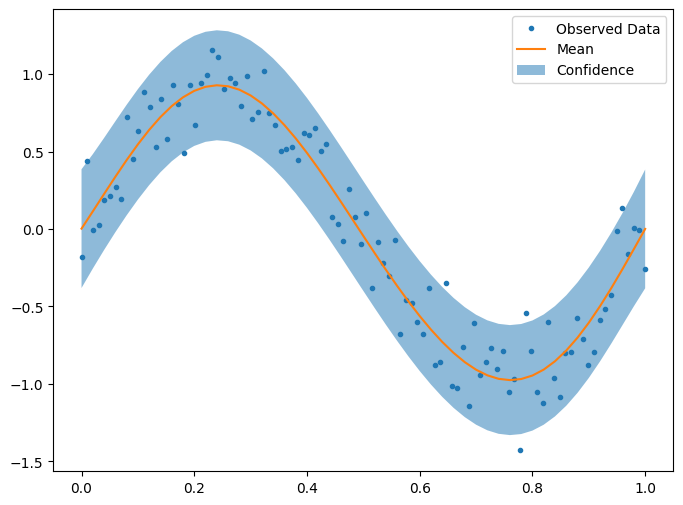

In [9]:
f = plot_model(observed_pred, train_x, train_y, test_x)

## Real world example

Construction of GP model for number of passengers of planes.

In [10]:
#!wget https://github.com/adasegroup/ML2020_seminars/raw/master/seminar11/data/airline.npz

--2024-02-22 09:01:15--  https://github.com/adasegroup/ML2020_seminars/raw/master/seminar11/data/airline.npz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adasegroup/ML2020_seminars/master/seminar11/data/airline.npz [following]
--2024-02-22 09:01:19--  https://raw.githubusercontent.com/adasegroup/ML2020_seminars/master/seminar11/data/airline.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2514 (2.5K) [application/octet-stream]
Saving to: ‘airline.npz.1’

airline.npz.1       100%[===================>]   2.46K  --.-KB/s    in 0s      

2024-02-22 09:01:20 (24.2 MB/s) - ‘airline.npz.1’ saved 

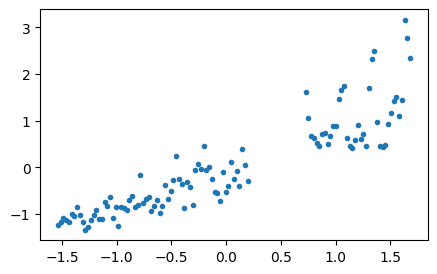

In [11]:
data = np.load("airline.npz")

X = data["X"][:, 0]
y = data["y"][:, 0]

train_indices = list(range(70)) + list(range(90, 129))
test_indices = range(70, 90)
X_train = X[train_indices]
y_train = y[train_indices]

# normalize data
mean_x = np.mean(X_train)
std_x = np.std(X_train)

mean_y = np.mean(y_train)
std_y = np.std(y_train)

X_train = (X_train - mean_x) / std_x
y_train = (y_train - mean_y) / std_y


X_test = (X[test_indices] - mean_x) / std_x
y_test = (y[test_indices] - mean_y) / std_y

plt.figure(figsize=(5, 3))
plt.plot(X_train, y_train, ".")
plt.show()

In [12]:
train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x_real = torch.tensor(X_test)
test_y_real = torch.tensor(y_test)
test_x = (torch.linspace(1948, 1964, 400, dtype=torch.float32) - mean_x) / std_x

### RBF kernel

In [13]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.RBFKernel()
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=50)

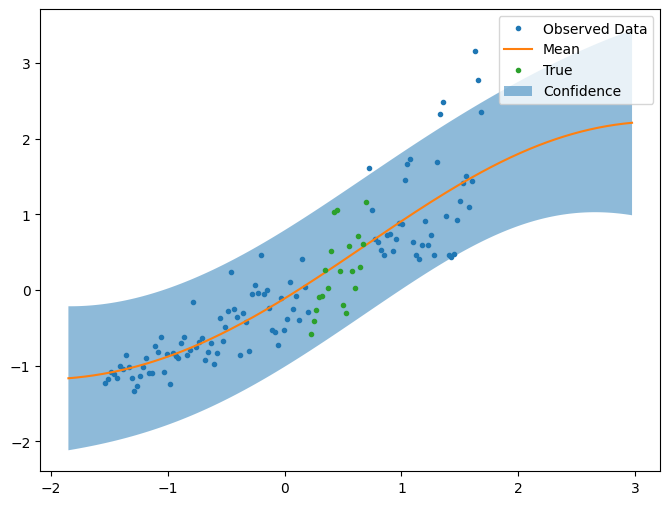

In [14]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

### Combining different kernels

Let us combine linear kernel, which picks up on trends, periodic kernel, which notice data seasonality, and RBF kernel, used to capture local nonlinearity

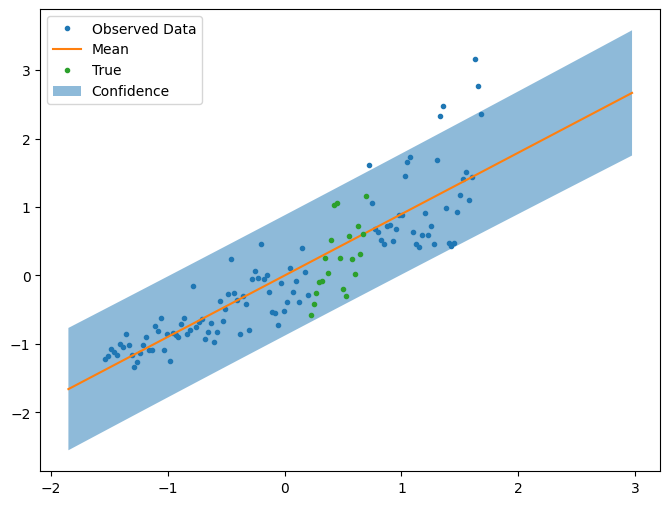

In [15]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.LinearKernel()
# covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

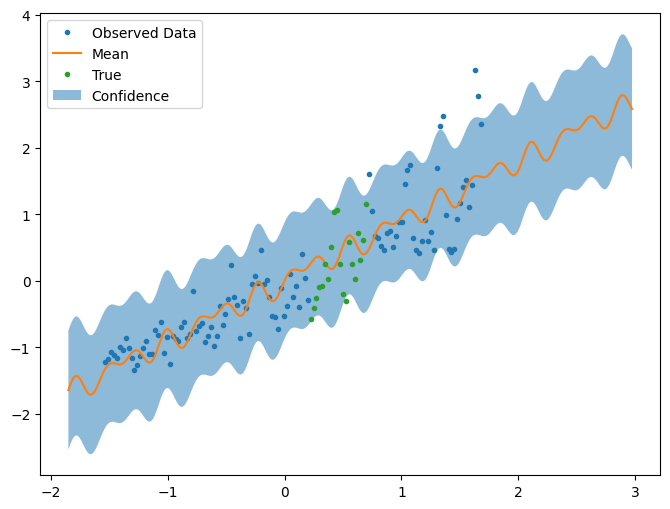

In [16]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.LinearKernel() + gpytorch.kernels.PeriodicKernel()
# covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

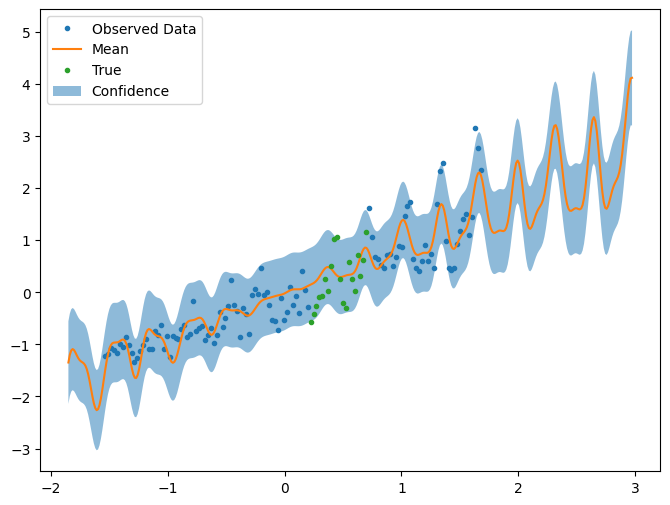

In [17]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.LinearKernel() * gpytorch.kernels.PeriodicKernel()
# covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

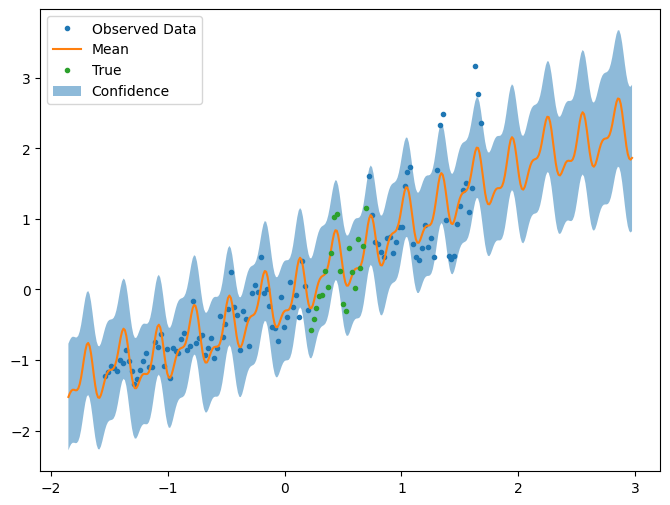

In [18]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.RBFKernel()
# covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

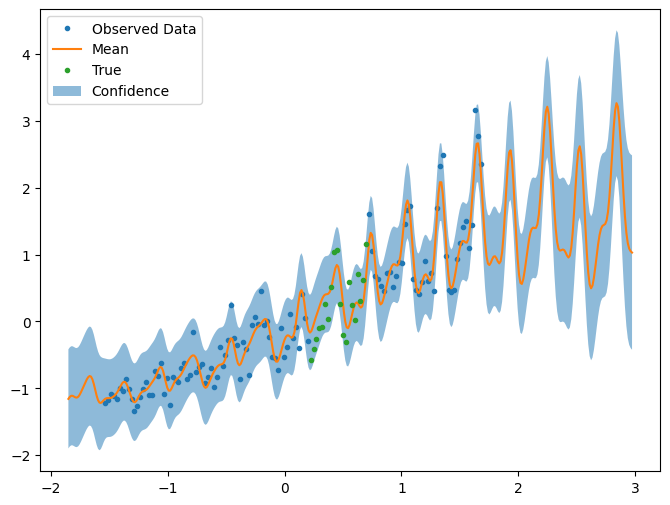

In [19]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.PeriodicKernel() * gpytorch.kernels.RBFKernel()
# covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

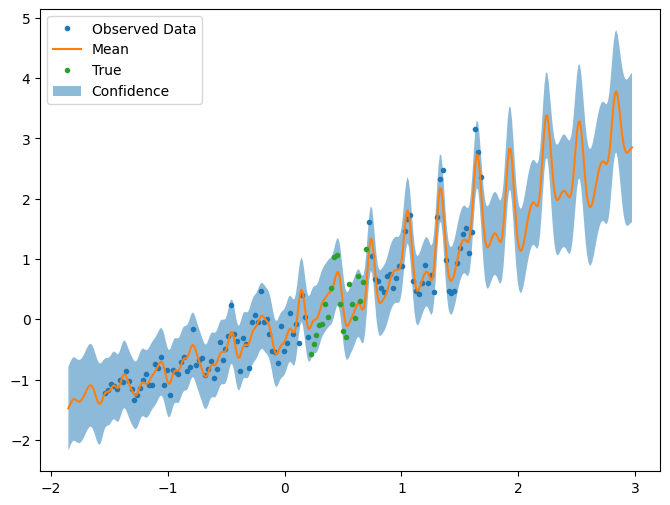

In [20]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.LinearKernel() * gpytorch.kernels.RBFKernel()
)
covar_module += gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel() * gpytorch.kernels.RBFKernel()
)
covar_module += gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

## Timeseries forcasting. An advanced example